In [36]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
path = "/home/nils/projects/uq-method-box/experiments/experiments/exp_results/results.csv"

df = pd.read_csv(path)

meta_cols = ["base_model", "loss_fn", "ensemble", "ensemble_members", "conformalized", "dataset_name", "pred_log_dir", "mlp_n_outputs", "date", "seed"]

# Preprocessing

In [43]:
# drop duplicate experiments and keep the one with the latest date
df = df.sort_values('date').drop_duplicates(meta_cols,keep='last').reset_index(drop=True)
df["ensemble"] = df["ensemble"].fillna("None") # should be handled when saving the dict
df = df[df["loss_fn"] != "quantile"] # discovered something wrong with quantile loss with huge nll so exclude at the moment

df["model_plot_name"] = df["base_model"] + "_" + df["loss_fn"] + "_" + df["ensemble"] # TODO come up with a unique model name for us to make easy plotting
df

,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,mae,rmse,...,loss_fn,ensemble,ensemble_members,conformalized,dataset_name,pred_log_dir,mlp_n_outputs,date,seed,model_plot_name
0,0.247352,0.217782,0.109974,1.078476,0.044592,0.039091,0.039365,0.419314,0.293801,0.437914,...,nll,None,1,False,energy,experiments/experiments/uci_gaussian_nll_03-02...,2,2023-03-02 17:27:05,0,gaussian_nll_nll_None
1,0.198250,0.209470,0.105775,1.073732,0.095481,0.078644,0.079249,0.383127,0.277400,0.432620,...,nll,None,1,False,energy,experiments/experiments/uci_gaussian_nll_03-02...,2,2023-03-02 17:27:05,1,gaussian_nll_nll_None
2,0.173742,0.204550,0.103288,1.051689,0.066579,0.051717,0.052047,0.333110,0.270773,0.422500,...,nll,None,1,False,energy,experiments/experiments/uci_gaussian_nll_03-02...,2,2023-03-02 17:27:05,2,gaussian_nll_nll_None
3,0.867292,0.355930,0.179697,1.988256,0.129396,0.108901,0.109942,0.721961,0.470608,0.790590,...,nll,None,1,False,boston,experiments/experiments/uci_gaussian_nll_03-02...,2,2023-03-02 17:27:20,2,gaussian_nll_nll_None
4,0.816512,0.336993,0.170097,1.897902,0.117151,0.099834,0.100824,0.623998,0.442127,0.774595,...,nll,None,1,False,boston,experiments/experiments/uci_gaussian_nll_03-02...,2,2023-03-02 17:27:20,1,gaussian_nll_nll_None
5,0.823358,0.332049,0.167662,1.828182,0.160209,0.145009,0.146459,0.701401,0.421948,0.721002,...,nll,None,1,False,boston,experiments/experiments/uci_gaussian_nll_03-02...,2,2023-03-02 17:27:20,0,gaussian_nll_nll_None
6,0.869514,0.351617,0.177549,1.836085,0.164360,0.143933,0.145376,0.864756,0.457056,0.756516,...,nll,None,1,True,boston,experiments/experiments/uci_gaussian_nll_03-02...,2,2023-03-02 17:27:37,2,gaussian_nll_nll_None
7,0.895455,0.362916,0.183246,1.912530,0.161295,0.135027,0.136239,0.877643,0.473815,0.796013,...,nll,None,1,True,boston,experiments/experiments/uci_gaussian_nll_03-02...,2,2023-03-02 17:27:37,0,gaussian_nll_nll_None
8,0.777992,0.340612,0.171982,1.796516,0.084285,0.070808,0.071277,0.747724,0.452261,0.773271,...,nll,None,1,True,boston,experiments/experiments/uci_gaussian_nll_03-02...,2,2023-03-02 17:27:37,1,gaussian_nll_nll_None
9,0.908708,0.346220,0.174754,1.997644,0.149927,0.126185,0.127445,0.664561,0.443290,0.761644,...,nll,deep_ensemble,3,True,boston,experiments/experiments/uci_gaussian_nll_03-02...,2,2023-03-02 17:28:08,1,gaussian_nll_nll_deep_ensemble


# Evaluate All Models across seeds on one dataset

This is in line with the plots in the Bayesian Wilson paper that we want to reproduce.

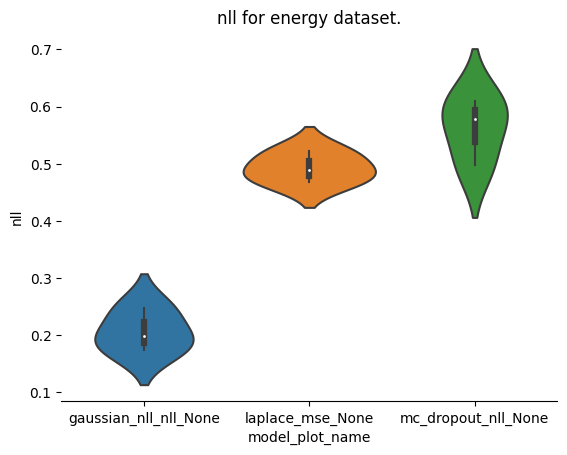

In [46]:
def evaluate_all_models_one_ds(dataset_name: str, metric: str, df: pd.DataFrame) -> None:
    """Evaluate all models on a single dataset.
    
    Args:
        dataset_name: name of dataset for which to plot results
        metric: name of the metric to visualize
    
    """
    dataset_df = df[df["dataset_name"] == dataset_name]
    dataset_df = dataset_df.drop_duplicates(["base_model", "loss_fn", "ensemble", "seed"]).reset_index(drop=True)
    dataset_df["model_plot_name"] = dataset_df["base_model"] + "_" + dataset_df["loss_fn"] + "_" + dataset_df["ensemble"]

    sns.violinplot(data=dataset_df, x="model_plot_name", y=metric)
    sns.despine(left=True)
    plt.title(f"{metric} for {dataset_name} dataset.")

evaluate_all_models_one_ds("energy", "nll", df)

# Evaluate a single model across datasets

This might be useful to check indidivual model performance and see what is going on.

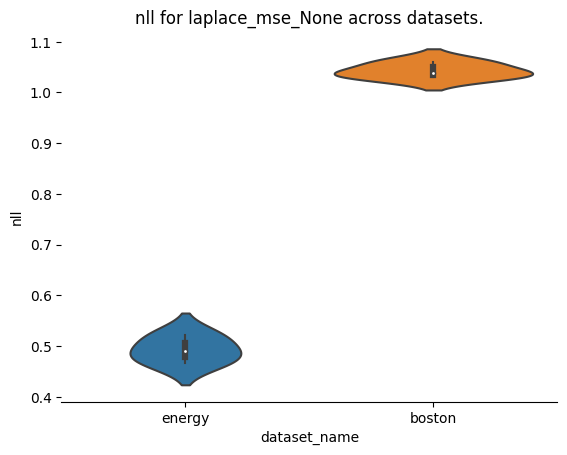

In [47]:
def evaluate_all_models_one_ds(model_name: str, metric: str, df: pd.DataFrame) -> None:
    """Evaluate all models on a single dataset.
    
    Args:
        dataset_name: name of dataset for which to plot results
        metric: name of the metric to visualize
    
    """
    dataset_df = df[df["model_plot_name"] == model_name]
    dataset_df = dataset_df.drop_duplicates(["base_model", "loss_fn", "ensemble", "seed", "dataset_name"]).reset_index(drop=True)

    sns.violinplot(data=dataset_df, x="dataset_name", y=metric)
    sns.despine(left=True)
    plt.title(f"{metric} for {model_name} across datasets.")

evaluate_all_models_one_ds("laplace_mse_None", "nll", df)

# Big Tables with numbers

Here we can autogenerate summary table for different things and also convert them to latex.

In [48]:
# TODO code here